In [2]:
from google.colab import files
files.upload()

Saving Titanic-Dataset.csv to Titanic-Dataset.csv


{'Titanic-Dataset.csv': b'PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked\r\n1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,,S\r\n2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C\r\n3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,,S\r\n4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S\r\n5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,,S\r\n6,0,3,"Moran, Mr. James",male,,0,0,330877,8.4583,,Q\r\n7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S\r\n8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.075,,S\r\n9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,,S\r\n10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,,C\r\n11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4,1,1,PP 9549,16.7,G6,S\r\n12,1,1,"Bonnell, Miss. Elizabeth",female,58,0,0,113783,26.55

## 1. Data Import and Initial Exploration 📊
✅ Dataset 'Titanic-Dataset.csv' loaded successfully.

--- Basic Info ---

[INFO] DataFrame Head:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3

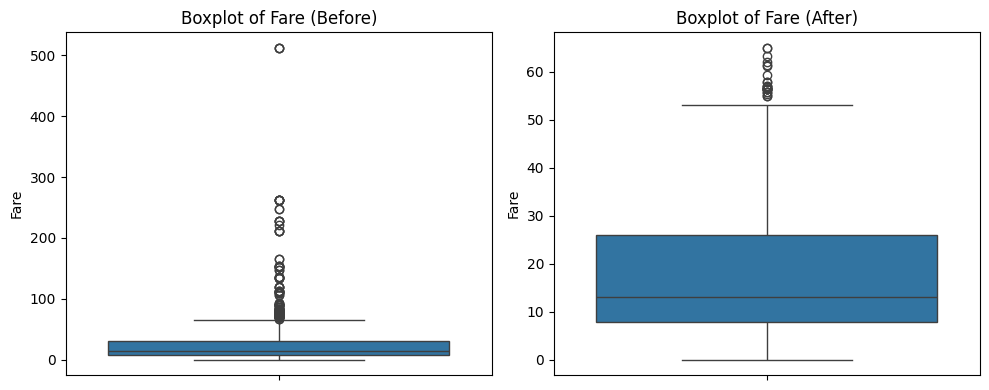


## 4. Feature Scaling (Standardization) 📏

[INFO] Final Preprocessed Features (X_scaled) Head:
        Age      Fare     SibSp     Parch  Pclass_1  Pclass_2  Pclass_3  \
0 -0.556219 -0.779117  0.625606 -0.433718       0.0       0.0       1.0   
1 -0.243027 -0.729373 -0.486423 -0.433718       0.0       0.0       1.0   
2  0.461654  2.599828  0.625606 -0.433718       1.0       0.0       0.0   
3  0.461654 -0.720161 -0.486423 -0.433718       0.0       0.0       1.0   
4  0.046606 -0.690071 -0.486423 -0.433718       0.0       0.0       1.0   

   Embarked_C  Embarked_Q  Embarked_S  Sex  
0         0.0         0.0         1.0  0.0  
1         0.0         0.0         1.0  1.0  
2         0.0         0.0         1.0  1.0  
3         0.0         0.0         1.0  0.0  
4         0.0         1.0         0.0  0.0  

[INFO] Final Feature Statistics (Numerical features should have mean ~0, std ~1):
       count          mean       std       min       25%       50%       75%  \
Age    775.0  3.9423

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- 1. Data Import and Initial Exploration ---
print("## 1. Data Import and Initial Exploration 📊")

FILE_NAME = 'Titanic-Dataset.csv' # Confirmed file name
try:
    df = pd.read_csv(FILE_NAME)
    print(f"✅ Dataset '{FILE_NAME}' loaded successfully.")
except FileNotFoundError:
    print(f"❌ ERROR: File '{FILE_NAME}' not found. Please re-upload or check the name.")
    exit()

print("\n--- Basic Info ---")
print("\n[INFO] DataFrame Head:")
print(df.head())
print("\n[INFO] Data Types and Missing Values Count:")
print(df.info())

# --- Feature Definitions (CORRECTED for Titanic Data) ---
TARGET_COL = 'Survived'
NUMERICAL_FEATURES = ['Age', 'Fare', 'SibSp', 'Parch'] # Age, Fare have NaNs; SibSp, Parch are counts.
NOMINAL_CATEGORICAL_FEATURES = ['Pclass', 'Embarked'] # Pclass (1, 2, 3) and Embarked (S, C, Q)
BINARY_FEATURES = ['Sex'] # male/female

# Columns that are too sparse or non-predictive for a basic model
COLUMNS_TO_DROP = ['PassengerId', 'Name', 'Ticket', 'Cabin']

# Drop irrelevant columns before processing
df = df.drop(columns=COLUMNS_TO_DROP, errors='ignore')

# --- Pre-processing for Binary Feature ('Sex') (Step 3: Encoding) ---
if BINARY_FEATURES and BINARY_FEATURES[0] in df.columns:
    binary_col = BINARY_FEATURES[0]
    # Map 'male' to 0 and 'female' to 1 (or vice versa)
    mapping = {'male': 0, 'female': 1}
    df[binary_col] = df[binary_col].map(mapping)
    print(f"\n[INFO] Binary feature '{binary_col}' mapped using: {mapping}")

# --- 2. Handling Missing Values & 3. Converting Categorical Features (using Pipeline) ---
print("\n## 2. & 3. Imputation and Encoding 🛠️")

# Define preprocessing steps
numerical_transformer = Pipeline(steps=[
    # Step 2: Impute missing values with the mean
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', 'passthrough')
])

categorical_transformer = Pipeline(steps=[
    # Handle missing 'Embarked' values by filling with the most frequent (mode)
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # Step 3: Convert categories into numerical columns
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, NUMERICAL_FEATURES),
        ('cat', categorical_transformer, NOMINAL_CATEGORICAL_FEATURES)
    ],
    remainder='passthrough' # Keeps the already mapped 'Sex' column
)

# Apply the transformations
features_to_process = [col for col in df.columns if col != TARGET_COL]
# This line now works because 'Survived' is the correct target column
df_processed_array = preprocessor.fit_transform(df.drop(columns=[TARGET_COL]))

# Reconstruct the DataFrame
ohe_feature_names = list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(NOMINAL_CATEGORICAL_FEATURES))
final_feature_names = NUMERICAL_FEATURES + ohe_feature_names + BINARY_FEATURES
df_processed = pd.DataFrame(df_processed_array, columns=final_feature_names)
df_processed[TARGET_COL] = df[TARGET_COL].values

print("\n[INFO] DataFrame after Imputation and Encoding:")
print(df_processed.head())
print(df_processed.info())

# --- 5. Visualize Outliers and Remove Them ---
print("\n## 5. Outlier Detection and Removal 🗑️")

# Outlier Removal Function (using IQR method)
def remove_outliers_iqr(df_in, col_name, threshold=1.5):
    Q1 = df_in[col_name].quantile(0.25)
    Q3 = df_in[col_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    return (df_in[col_name] >= lower_bound) & (df_in[col_name] <= upper_bound)

# Visualize and remove outliers from 'Fare' (a common outlier in Titanic data)
feature_to_check = 'Fare'

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.boxplot(y=df_processed[feature_to_check])
plt.title(f'Boxplot of {feature_to_check} (Before)')

outlier_mask = remove_outliers_iqr(df_processed, feature_to_check)
df_cleaned = df_processed[outlier_mask].copy()

print(f"\n[INFO] Rows before cleaning: {len(df_processed)}")
print(f"[INFO] Rows after cleaning: {len(df_cleaned)} (Removed {len(df_processed) - len(df_cleaned)} outlier(s))")

plt.subplot(1, 2, 2)
sns.boxplot(y=df_cleaned[feature_to_check])
plt.title(f'Boxplot of {feature_to_check} (After)')
plt.tight_layout()
plt.show()
#

# --- 4. Normalize/Standardize the Numerical Features ---
print("\n## 4. Feature Scaling (Standardization) 📏")

# Separate features (X) and target (y)
X = df_cleaned.drop(TARGET_COL, axis=1)
y = df_cleaned[TARGET_COL]

# Define the final numerical transformer with StandardScaler
numerical_transformer_final = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create the final preprocessor to scale only the necessary columns
final_scaler = ColumnTransformer(
    transformers=[
        ('num_scale', numerical_transformer_final, NUMERICAL_FEATURES),
    ],
    remainder='passthrough'
)

# Apply the final scaling transformation
X_scaled_array = final_scaler.fit_transform(X)

# Convert the final array back to a DataFrame
X_scaled = pd.DataFrame(X_scaled_array, columns=X.columns)

print("\n[INFO] Final Preprocessed Features (X_scaled) Head:")
print(X_scaled.head())
print("\n[INFO] Final Feature Statistics (Numerical features should have mean ~0, std ~1):")
print(X_scaled[NUMERICAL_FEATURES].describe().T)
print("\n✅ Data Preprocessing Complete! X_scaled and y are ready for ML model training.")